In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import dendrotweaks as dd
dd.__version__

'0.4.6'

In [3]:
dd.apply_dark_theme() # Set the theme for the plots

# Model

In [4]:
path_to_model = os.getcwd()
print(f'Path to model: {path_to_model}')
path_to_data = os.path.dirname(path_to_model)
print(f'Path to data: {path_to_data}')

Path to model: /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Toy
Path to data: /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples


In [5]:
model = dd.Model(path_to_model)

In [6]:
model.list_morphologies()

['ball-and-stick', 'point', 'simple-cell']

Let's first load and visualize the morphology.

In [7]:
model.load_morphology(file_name='simple-cell')

Sorted PointTree(root=Point(idx=0), num_nodes=17).
Apical dendrite is already aligned.
Extended 6 nodes.
Sorted PointTree(root=Point(idx=0), num_nodes=23).


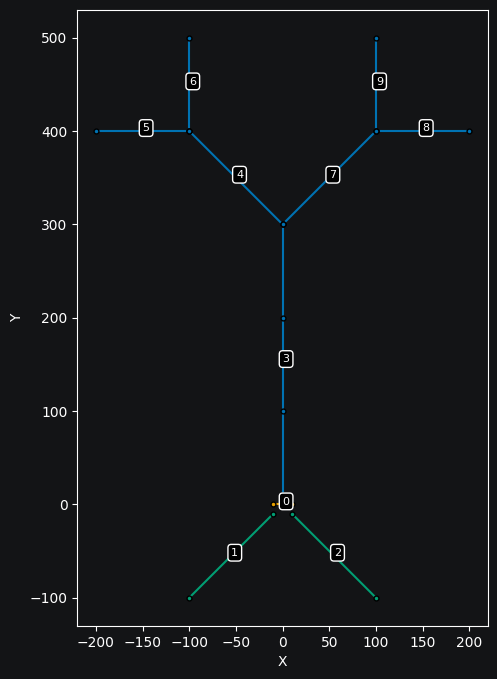

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
model.sec_tree.plot(ax, 
                    show_points=True,
                    show_lines=True,
                    annotate=True)

We will also update the segmentation (nseg) using the d_lambda rule:

In [9]:
model.set_param('Ra', value=100)

In [10]:
model.set_segmentation(d_lambda=0.1)
len(model.seg_tree)

44

# Mechanisms

we will add some default mechanisms, from which we will need only the Leak channel. Note that in DendroTweaks the NEURON `pas` mechanism is replaced by a `Leak` channel with `gbar_Leak` and `e_Leak` parameters.

In [ ]:
model.add_default_mechanisms() # Leak, Ca dynamics and Synapses

Next, let's list all available user-defined mechanisms in the `biophys/mod` directory. 

In [ ]:
model.list_mechanisms()

['stdNa',
 'NaKinetic',
 'Na',
 'stdKv',
 'KCa',
 'Kv',
 'Ka',
 'CaHVA',
 'Km',
 'CaLVA']

We will add only the sodium (Na) and potasiium (Kv) channels. 

In [13]:
for mech in ['Na', 'Kv']:
    model.add_mechanism(mech)

Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Toy/biophys/python/Na.py
Saved content to /home/roman/Documents/code/DendroTweaksLab/DendroTweaks/examples/Toy/biophys/python/Kv.py


In [14]:
model.mechanisms

{'Leak': <Mechanism(Leak)>,
 'CaDyn': <Mechanism(CaDyn)>,
 'Na': <Mechanism(Na)>,
 'Kv': <Mechanism(Kv)>}

We need to insert the mechanisms into all domains.

In [ ]:
for domain_name in model.domains:
    for mech_name in ['Leak', 'Na', 'Kv']:
            model.insert_mechanism(mech_name, domain_name, distribute=False)

# Parameters

We will use the segment groups created for each of the domains by default.

In [16]:
model.groups

{'all': SegmentGroup("all", domains=['apic', 'dend', 'soma']),
 'apical': SegmentGroup("apical", domains=['apic']),
 'dendritic': SegmentGroup("dendritic", domains=['dend']),
 'somatic': SegmentGroup("somatic", domains=['soma'])}

In [17]:
model.set_param('gbar_Leak', value=0.00015)

# Na
model.set_param('gbar_Na', group_name='somatic', distr_type='constant', value=0.05)
model.set_param('gbar_Na', group_name='dendritic', distr_type='constant', value=0.03)
model.set_param('gbar_Na', group_name='apical', distr_type='constant', value=0.03)

# Kv
model.set_param('gbar_Kv', group_name='somatic', distr_type='constant', value=0.005)
model.set_param('gbar_Kv', group_name='dendritic', distr_type='constant', value=0.0015)
model.set_param('gbar_Kv', group_name='apical', distr_type='constant', value=0.0015)

We can now display the model parameters as a dataframe. Note that alongside the channel conductances we explicitly defined, there are also kinetic parameters with constant values across all segments, which are derived from the MOD files.

In [18]:
model.df_params

,Mechanism,Parameter,Group,Distribution,Distribution params
0,Independent,cm,all,constant,{'value': 1}
1,Independent,Ra,all,constant,{'value': 100}
2,Independent,ena,all,constant,{'value': 50}
3,Independent,ek,all,constant,{'value': -77}
4,Leak,gbar_Leak,all,constant,{'value': 0.00015}
5,Leak,e_Leak,all,constant,{'value': -70}
6,Na,gbar_Na,all,constant,{'value': 0.0}
7,Na,gbar_Na,somatic,constant,{'value': 0.05}
8,Na,gbar_Na,dendritic,constant,{'value': 0.03}
9,Na,gbar_Na,apical,constant,{'value': 0.03}


Finally, we can export the parameters to a JSON file: `biophys/simple_cell_biophys.json`

In [ ]:
model.export_biophys(file_name='simple_cell_biophys')

# Simulation

In [20]:
soma = model.sec_tree[0]
model.remove_all_stimuli()
model.remove_all_recordings()

model.add_recording(soma, loc=0.5)
model.add_iclamp(soma, loc=0.5, amp=0.05, delay=100, dur=800)

Recording added to sec NeuronSection(idx=0) at loc 0.5.
IClamp added to sec NeuronSection(idx=0) at loc 0.5.


In [ ]:
model.simulator.run(1000); #ms

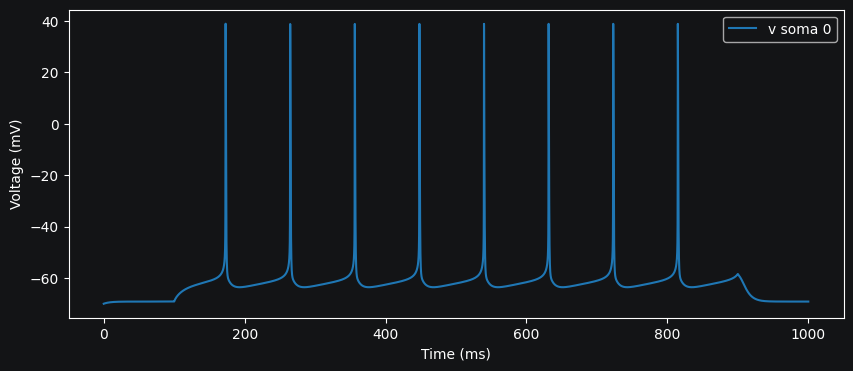

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
model.simulator.plot_voltage(ax=ax)

In [23]:
model.export_stimuli(file_name='depolarizing_current') # Export the stimuli to JSON and CSV files